# Example for PV self-consumption

* Import the function needed for this example

In [1]:
from example_utils import *

### STEP 1: Create an empty optimization model

In [2]:
model = OptimisationModel(name='example')

### STEP 2: Set the time periods

*5 minutes time step:* dt=1/12 hours

*Daily study:* periods = 24 hours (24*12 time steps)

In [3]:
time = TimeUnit(periods=24*12, dt=1/12)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-01 23:55:00


### STEP 3: Create the household consumption units

* Import the domestic hot water load profile


In [4]:
dhw_load = import_domestic_hot_water_load_profile()

* Import the lothes washing machine and dryer load profiles*

In [5]:
cl_wash_load, cl_dry_load = import_clothes_washer_and_dryer_load_profiles()

* Create the consumption models
    * A **FixedConsumptionUnit** is used for known load profiles
    * **ShiftableConsumptionUnit** are used for load profiles that can be shifted during time.

In [6]:
dhw = FixedConsumptionUnit(time, 'dhw', energy_type='Heat', p=dhw_load)

clothes_washer = ShiftableConsumptionUnit(time, name='clothes_washer',
                                          power_values=cl_wash_load,
                                          energy_type='Electrical')

clothes_dryer = ShiftableConsumptionUnit(time, name='clothes_dryer',
                                         power_values=cl_dry_load,
                                         energy_type='Electrical')

Creating the dhw.
Creating the clothes_washer.
Creating the clothes_dryer.


### STEP 4: Create the PV panels and the grid imports and exports

* Import the electrical production from PV panels

In [7]:
PV_prod_profile = import_PV_profile_5_min()

*	Create the PV production model

In [8]:
PV_prod = FixedProductionUnit(time, name='PV_prod', p=PV_prod_profile)

Creating the PV_prod.


* Create the electrical grid imports as a production
    * A **VariableProductionUnit** is used for unknown production profiles
        + Minimal/maximal power of operation can be set with pmin/pmax
        + Maximal ramping values (up/down) can be fixed with max_ramp_up/max_ramp_down
        + Here, these parameters are free to model an infinite power grid

In [9]:
elec_grid_imports = VariableProductionUnit(time, 'elec_grid_imports',
                                           energy_type='Electrical')

Creating the elec_grid_imports.


* Create the electrical grid exports as a consumption

    * A **VariableConsumptionUnit** is used for unknown consumption profiles
        + Here, parameters are free to model an infinite power grid

In [10]:
elec_grid_exports = VariableConsumptionUnit(time, 'elec_grid_exports',
                                            energy_type='Electrical')

Creating the elec_grid_exports.


### STEP 5: Avoid importing and exporting at the same time
* Create the **ExtDynConstraint** which inherits from:
    * **DynamicConstraint** for a time-dependant constraint
    * **ExternalConstraint** for a constraint not expressing a physical law or a variable calculation
* Set the time-dependant expression
    * u indicates if the EnergyUnit is operating, so that: unit_1_u(t) + unit_2_u(t) <= 1.5 avoid a simultaneous operation
    * t_range expresses the set of index for whom the constraint should be considered

In [11]:
imp_exp = ExtDynConstraint(name='imp_exp',
                           exp_t='elec_grid_imports_u[t] + '
                                 'elec_grid_exports_u[t] <= 1.5',
                           t_range='for t in time.I',
                           parent=elec_grid_imports)

* Add the constraint to the elec_grid_imports model


In [12]:
setattr(elec_grid_imports, 'imp_exp', imp_exp)

### STEP 6: Create the water heater and the water tank

* Create the water heater as an **ElectricalToHeatConversionUnit** with:
    * A ratio of conversion from electricty to heat of 90%
    * A maximal power for the electricity consumption of 6kW (6000W)

In [13]:
water_heater = ElectricalToHeatConversionUnit(time, 'water_heater',
                                              elec_to_heat_ratio=0.9,
                                              pmax_in_elec=6000)

Creating the water_heater_heat_prod.
Creating the water_heater_elec_cons.
Creating the water_heater.


* Define the tank capacity of 6kWh (6000Wh)

In [14]:
tank_capacity = 6000

* Define a minimal state of charge for the storage of 20%

In [15]:
SoC_min = 0.2

* Define losses with a self-discharge parameter of 5% per hour

In [16]:
self_disch = 0.05 * time.DT

* Define if the state of charge of the storage has to be regained at the end of the time period (yes)

In [17]:
is_cycling = True

* Create the storage model with **StorageUnit**

In [18]:
water_tank = StorageUnit(time, 'water_tank', capacity=tank_capacity,
                         energy_type='Heat', ef_is_e0=is_cycling,
                         self_disch=self_disch, soc_min=SoC_min)

Creating the water_tank.


### STEP 7: Avoid that the dryer starts before the end of the washing machine cycle

* Create the **ExtDynConstraint**
* Set the time-dependant expression
    * The expression avoid that the clothes_dryer starts before that the clothes washer switched off
    * *start_up* indicates if the **EnergyUnit** is starting
    * *switch_off* indicates if the **EnergyUnit**

In [19]:
wait_to_dry = ExtDynConstraint(name='wait_to_dry',
                               exp_t='clothes_dryer_start_up[t] <= '
                                     'lpSum(clothes_washer_switch_off[k] '
                                     'for k in range(0, t))',
                               t_range='for t in time.I',
                               parent=clothes_dryer)

* Add the constraint to the dryer model

In [20]:
setattr(clothes_dryer, 'wait_to_dry', wait_to_dry)

### STEP 8: Define the objective
* Maximizing the self-consumption means minimizing the imports from the elctrical grid

In [21]:
elec_grid_imports.minimize_production()

### STEP 9: Create the energy nodes
* Creating the heat node

In [22]:
heat_node = EnergyNode(time, 'heat__node', energy_type='Heat')

Creating the heat__node.


* Connect the thermal units to the heat node

In [23]:
heat_node.connect_units(dhw, water_tank, water_heater.heat_production_unit)


* Create the electrical node

In [24]:
elec_node = EnergyNode(time, 'elec_node', energy_type='Electrical')


Creating the elec_node.


* Connect the electrical units to the electrical node

In [25]:
elec_node.connect_units(clothes_washer, clothes_dryer, elec_grid_imports,
                        elec_grid_exports, PV_prod,
                        water_heater.elec_consumption_unit)

### STEP 10: Add the energy nodes to the optimization model

In [26]:
model.add_nodes(elec_node, heat_node)


--- Adding all variables to the model ---
Adding variable : clothes_washer_p
Adding variable : clothes_washer_e_tot
Adding variable : clothes_washer_u
Adding variable : clothes_washer_start_up
Adding variable : clothes_washer_switch_off
Adding variable : clothes_washer_power_values
Adding variable : clothes_dryer_p
Adding variable : clothes_dryer_e_tot
Adding variable : clothes_dryer_u
Adding variable : clothes_dryer_start_up
Adding variable : clothes_dryer_switch_off
Adding variable : clothes_dryer_power_values
Adding variable : elec_grid_imports_p
Adding variable : elec_grid_imports_e_tot
Adding variable : elec_grid_imports_u
Adding variable : elec_grid_exports_p
Adding variable : elec_grid_exports_e_tot
Adding variable : elec_grid_exports_u


Adding variable : PV_prod_p
Adding variable : PV_prod_e_tot
Adding variable : PV_prod_u
Adding variable : water_heater_elec_cons_p
Adding variable : water_heater_elec_cons_e_tot
Adding variable : water_heater_elec_cons_u
Adding variable : water_heater_heat_prod_p
Adding variable : water_heater_heat_prod_e_tot
Adding variable : water_heater_heat_prod_u
Adding variable : dhw_p
Adding variable : dhw_e_tot
Adding variable : dhw_u
Adding variable : water_tank_p
Adding variable : water_tank_e_tot
Adding variable : water_tank_u
Adding variable : water_tank_capacity
Adding variable : water_tank_e
Adding variable : water_tank_pc
Adding variable : water_tank_pd
Adding variable : water_tank_uc

--- Adding all objectives to the model ---
Adding objective : elec_grid_imports_min_production

--- Adding all constraints to the model ---
Adding constraint : elec_node_power_balance , exp = -clothes_washer_p[t]-clothes_dryer_p[t]+elec_grid_imports_p[t]-elec_grid_exports_p[t]+PV_prod_p[t]-water_heater_ele

Adding constraint : clothes_washer_def_2_power_value , exp = clothes_washer_p[t] >= clothes_washer_power_values[2] * clothes_washer_start_up[t-2] for t in time.I[2:-1]
Adding constraint : clothes_washer_def_3_power_value , exp = clothes_washer_p[t] >= clothes_washer_power_values[3] * clothes_washer_start_up[t-3] for t in time.I[3:-1]
Adding constraint : clothes_washer_def_4_power_value , exp = clothes_washer_p[t] >= clothes_washer_power_values[4] * clothes_washer_start_up[t-4] for t in time.I[4:-1]
Adding constraint : clothes_washer_def_5_power_value , exp = clothes_washer_p[t] >= clothes_washer_power_values[5] * clothes_washer_start_up[t-5] for t in time.I[5:-1]


Adding constraint : clothes_washer_def_6_power_value , exp = clothes_washer_p[t] >= clothes_washer_power_values[6] * clothes_washer_start_up[t-6] for t in time.I[6:-1]
Adding constraint : clothes_dryer_set_e_min , exp = time.DT * lpSum(clothes_dryer_p[t] for t in time.I[:]) >= 1427.0
Adding constraint : clothes_dryer_set_e_max , exp = time.DT * lpSum(clothes_dryer_p[t] for t in time.I[:]) <= 1427.0
Adding constraint : clothes_dryer_on_off_max , exp = clothes_dryer_p[t] <= clothes_dryer_u[t] * 2914.0 for t in time.I
Adding constraint : clothes_dryer_on_off_min , exp = clothes_dryer_p[t] >= clothes_dryer_u[t] * 1e-05 for t in time.I
Adding constraint : clothes_dryer_calc_e_tot , exp = clothes_dryer_e_tot == time.DT * lpSum(clothes_dryer_p[t] for t in time.I)
Adding constraint : clothes_dryer_def_start_up , exp = clothes_dryer_u[t+1] - clothes_dryer_u[t] <= clothes_dryer_start_up[t+1] for t in time.I[:-1]
Adding constraint : clothes_dryer_def_no_start_up , exp = clothes_dryer_start_up[t+1

Adding constraint : clothes_dryer_def_4_power_value , exp = clothes_dryer_p[t] >= clothes_dryer_power_values[4] * clothes_dryer_start_up[t-4] for t in time.I[4:-1]
Adding constraint : clothes_dryer_def_5_power_value , exp = clothes_dryer_p[t] >= clothes_dryer_power_values[5] * clothes_dryer_start_up[t-5] for t in time.I[5:-1]
Adding constraint : clothes_dryer_def_6_power_value , exp = clothes_dryer_p[t] >= clothes_dryer_power_values[6] * clothes_dryer_start_up[t-6] for t in time.I[6:-1]


Adding constraint : clothes_dryer_def_7_power_value , exp = clothes_dryer_p[t] >= clothes_dryer_power_values[7] * clothes_dryer_start_up[t-7] for t in time.I[7:-1]
Adding constraint : clothes_dryer_def_8_power_value , exp = clothes_dryer_p[t] >= clothes_dryer_power_values[8] * clothes_dryer_start_up[t-8] for t in time.I[8:-1]
Adding constraint : clothes_dryer_def_9_power_value , exp = clothes_dryer_p[t] >= clothes_dryer_power_values[9] * clothes_dryer_start_up[t-9] for t in time.I[9:-1]


Adding constraint : clothes_dryer_wait_to_dry , exp = clothes_dryer_start_up[t] <= lpSum(clothes_washer_switch_off[k] for k in range(0, t)) for t in time.I


Adding constraint : elec_grid_imports_on_off_max , exp = elec_grid_imports_p[t] <= elec_grid_imports_u[t] * 100000.0 for t in time.I
Adding constraint : elec_grid_imports_on_off_min , exp = elec_grid_imports_p[t] >= elec_grid_imports_u[t] * 1e-05 for t in time.I
Adding constraint : elec_grid_imports_calc_e_tot , exp = elec_grid_imports_e_tot == time.DT * lpSum(elec_grid_imports_p[t] for t in time.I)
Adding constraint : elec_grid_imports_imp_exp , exp = elec_grid_imports_u[t] + elec_grid_exports_u[t] <= 1.5 for t in time.I
Adding constraint : elec_grid_exports_on_off_max , exp = elec_grid_exports_p[t] <= elec_grid_exports_u[t] * 100000.0 for t in time.I
Adding constraint : elec_grid_exports_on_off_min , exp = elec_grid_exports_p[t] >= elec_grid_exports_u[t] * 1e-05 for t in time.I
Adding constraint : elec_grid_exports_calc_e_tot , exp = elec_grid_exports_e_tot == time.DT * lpSum(elec_grid_exports_p[t] for t in time.I)
Adding constraint : PV_prod_on_off_max , exp = PV_prod_p[t] <= PV_pro

Adding constraint : dhw_on_off_max , exp = dhw_p[t] <= dhw_u[t] * 4560.0 for t in time.I
Adding constraint : dhw_on_off_min , exp = dhw_p[t] >= dhw_u[t] * 0.0 for t in time.I
Adding constraint : dhw_calc_e_tot , exp = dhw_e_tot == time.DT * lpSum(dhw_p[t] for t in time.I)
Adding constraint : water_tank_on_off_max , exp = water_tank_p[t] <= water_tank_u[t] * 100000.0 for t in time.I
Adding constraint : water_tank_on_off_min , exp = water_tank_p[t] >= water_tank_u[t] * -100000.0 for t in time.I
Adding constraint : water_tank_calc_e_tot , exp = water_tank_e_tot == time.DT * lpSum(water_tank_p[t] for t in time.I)
Adding constraint : water_tank_set_soc_min , exp = water_tank_e[t] >= 0.2 * water_tank_capacity for t in time.I
Adding constraint : water_tank_set_soc_max , exp = water_tank_e[t] <= 1 * water_tank_capacity for t in time.I
Adding constraint : water_tank_calc_e , exp = water_tank_e[t+1] - water_tank_e[t]*(1-0) +0.004166666666666667*water_tank_capacity - time.DT * (water_tank_pc[t]*1

### STEP 11: Launch the optimization

* Write and store the model in the .lp format (*can be skipped off-line*)

In [27]:
model.writeLP('example.lp')

In [28]:
model.solve_and_update()


 - - - - - RUN OPTIMIZATION - - - - - 



 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : clothes_washer
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : start_up
	Quantity : switch_off
	Quantity : power_values
Updating unit : clothes_dryer
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : start_up
	Quantity : switch_off
	Quantity : power_values
Updating unit : elec_grid_imports
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : elec_grid_exports
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : PV_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : water_heater_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : water_heater
Updating unit : water_heater_heat_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat__node
Updating unit : dhw
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : water_tank
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc


### STEP 12: Plot the results


Preparing to plot the energetic flows through the node heat__node.
	Add power from dhw.


	Add power from water_tank.


	Add power from water_heater_heat_prod.

Preparing to plot the energetic flows through the node elec_node.
	Add power from clothes_washer.


	Add power from clothes_dryer.


	Add power from elec_grid_imports.
	Add power from elec_grid_exports.


	Add power from PV_prod.
	Add power from water_heater_elec_cons.


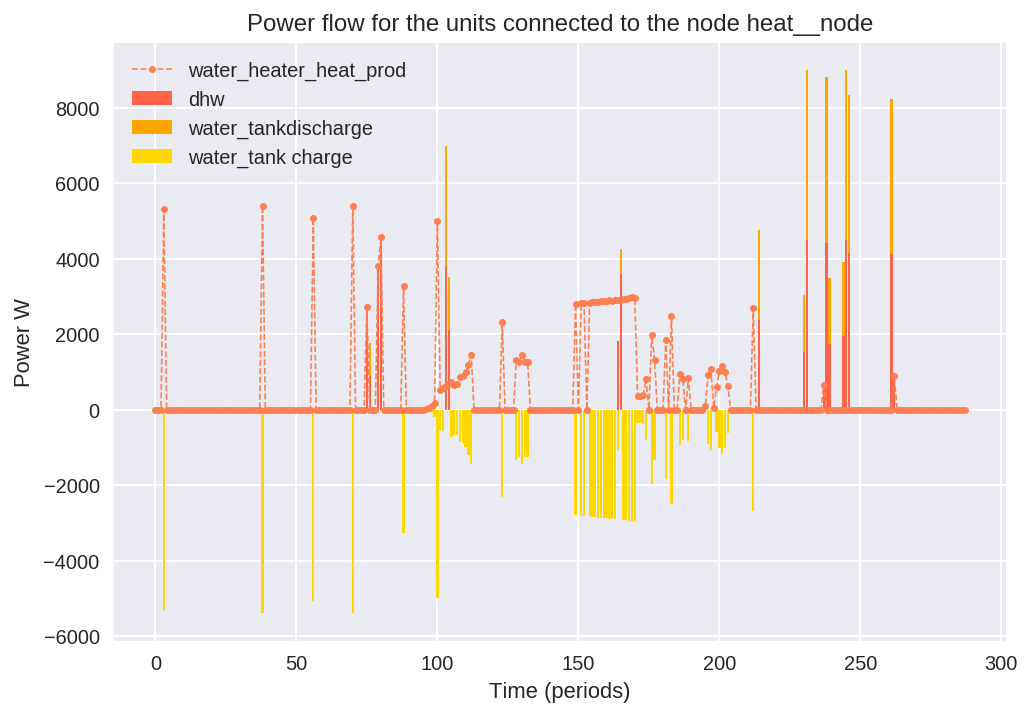

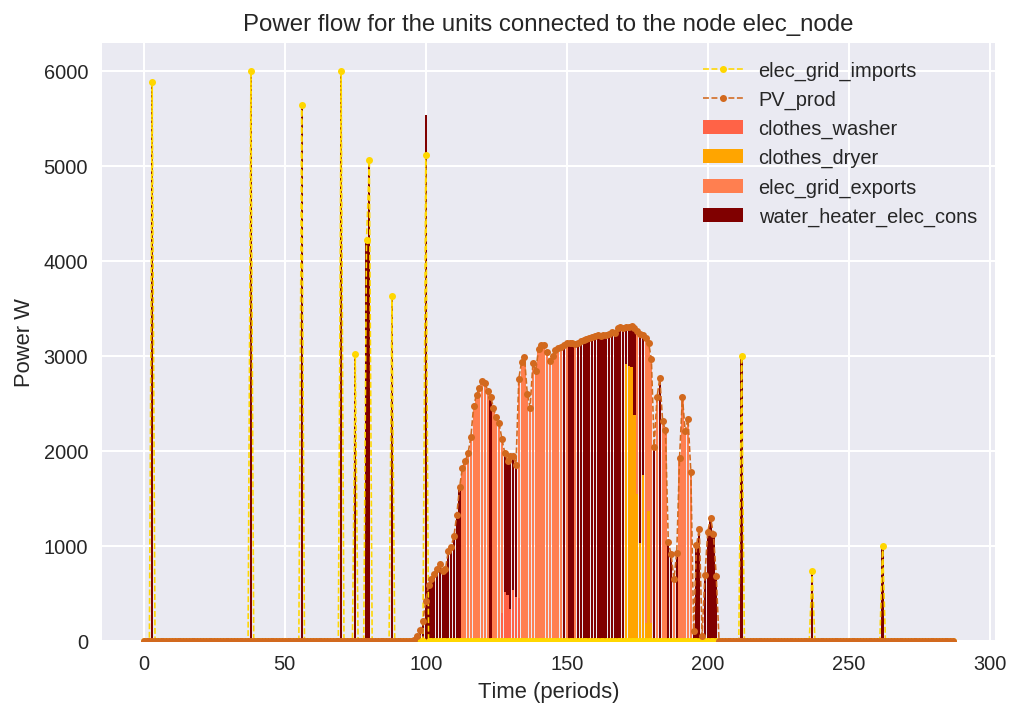

In [29]:
plot_node_energetic_flows(heat_node, p_unit='W')
plot_node_energetic_flows(elec_node, p_unit='W')
plt.show()